## astroNN Variational Autoencoder demo with 1D data

https://notebook.community/henrysky/astroNN/demo_tutorial/VAE/.ipynb_checkpoints/variational_autoencoder_demo-checkpoint


In [1]:
import numpy as np
import pylab as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

import tensorflow as tf
from astroNN.nn.layers import KLDivergenceLayer
from astroNN.nn.losses import nll
tf.compat.v1.disable_eager_execution()


2023-03-21 21:41:09.093036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
original_dim = 4000  # Our 1D images dimension, each image has 4000 pixel
intermediate_dim = 256  # Number of neurone our fully connected neural net has

batch_size = 50
epochs = 15
epsilon_std = 1.0


def blackbox_image_generator(pixel, center, sigma):
    return norm.pdf(pixel, center, sigma)


def model_vae(latent_dim):
    """ 
    Main Model + Encoder
    """
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)

    z_mu = Dense(latent_dim, kernel_regularizer=regularizers.l2(1e-4))(h)
    z_log_var = Dense(latent_dim)(h)

    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: tf.exp(.5*t))(z_log_var)

    eps = Input(tensor=tf.random.normal(mean=0, stddev=epsilon_std, shape=(tf.shape(x)[0], latent_dim)))
    
    z_eps = Multiply()([z_sigma, eps])
    z = Add()([z_mu, z_eps])
    
    decoder = Sequential()
    decoder.add(Dense(intermediate_dim, input_dim=latent_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    
    x_pred = decoder(z)

    vae = Model(inputs=[x, eps], outputs=x_pred)
    
    encoder = Model(x, z_mu)
    
    return vae, encoder



Now we will generate some true latent variable so we can pass them to a blackbox image generator to generate some 1D images.

The blackbox image generator (which is deterministic) will take two numbers and generate images in a predictable way. This is important because if the generator generate image in a random way, then there is nothing neural network can learn.

But for simplicity, we will fix the first latent variable of the blackbox image generator a constant and only use the second one to generate images.


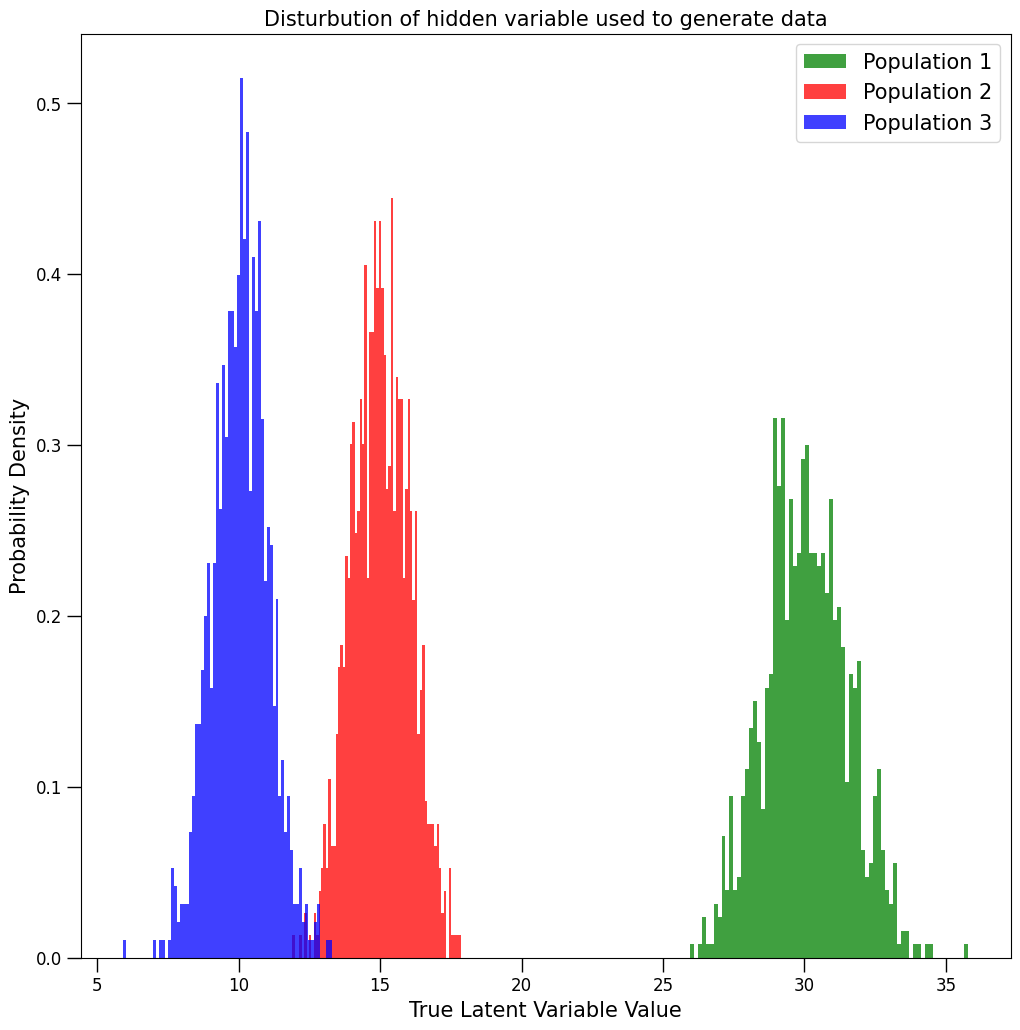

In [3]:
s_1 = np.random.normal(30, 1.5, 900)
s_2 = np.random.normal(15, 1, 900)
s_3 = np.random.normal(10, 1, 900)

s = np.concatenate([s_1, s_2, s_3])

plt.figure(figsize=(12, 12))
plt.hist(s[:900], 70, density=1, facecolor='green', alpha=0.75, label='Population 1')
plt.hist(s[900:1800], 70, density=1, facecolor='red', alpha=0.75, label='Population 2')
plt.hist(s[1800:], 70, density=1, facecolor='blue', alpha=0.75, label='Population 3')
plt.title('Disturbution of hidden variable used to generate data', fontsize=15)
plt.xlabel('True Latent Variable Value', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

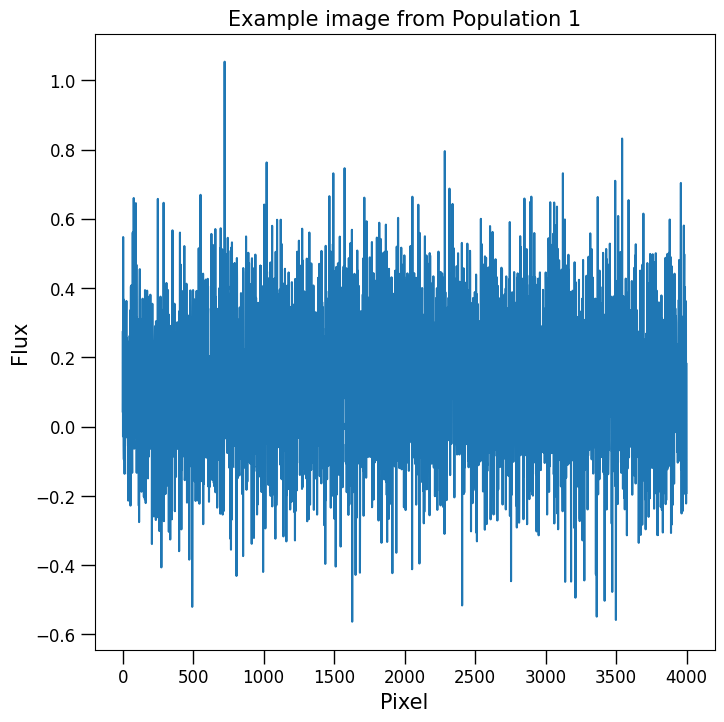

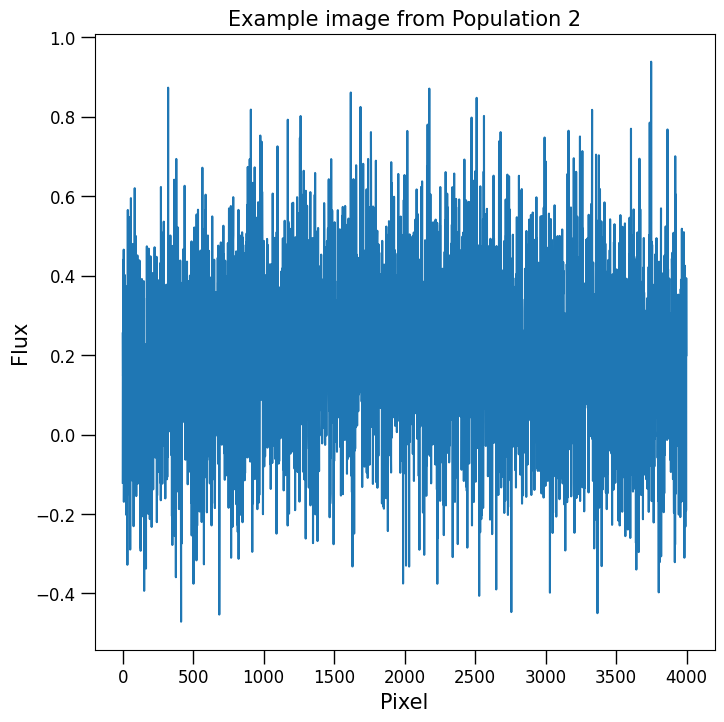

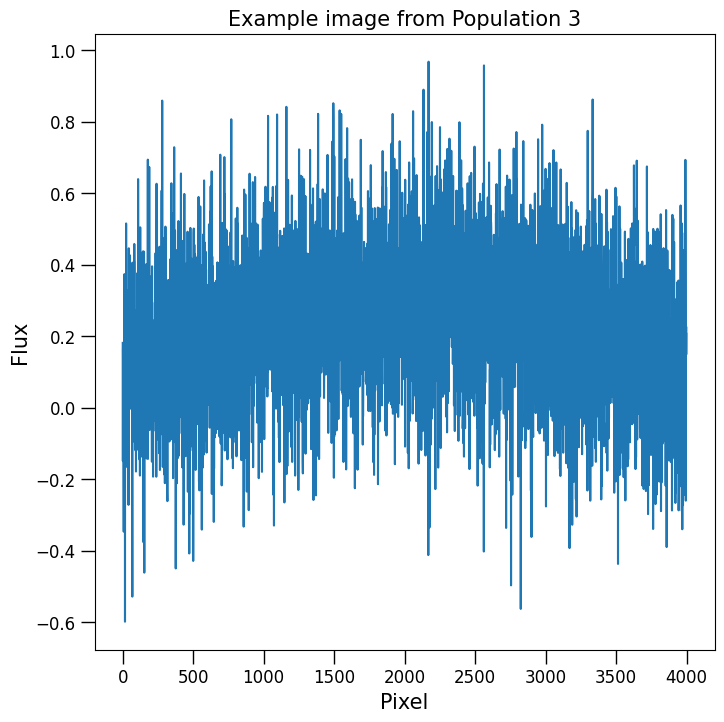

In [4]:
# We have some images, each has 4000 pixels
x_train = np.zeros((len(s), original_dim))
for counter, S in enumerate(s):
    xs = np.linspace(0, 40, original_dim)
    x_train[counter] = blackbox_image_generator(xs, 20, S)

# Prevent nan causes error
x_train[np.isnan(x_train.astype(float))] = 0

x_train *= 10

# Add some noise to our images
x_train += np.random.normal(0, 0.2, x_train.shape)

plt.figure(figsize=(8, 8))
plt.title('Example image from Population 1', fontsize=15)
plt.plot(x_train[500])
plt.xlabel('Pixel', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.show()

plt.figure(figsize=(8, 8))
plt.title('Example image from Population 2', fontsize=15)
plt.plot(x_train[1000])
plt.xlabel('Pixel', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.show()

plt.figure(figsize=(8, 8))
plt.title('Example image from Population 3', fontsize=15)
plt.plot(x_train[1600])
plt.xlabel('Pixel', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.show()

Now we will pass the images to the neural network and train with them.

2023-03-21 21:41:20.575778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 21:41:20.604296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-21 21:41:20.656290: W tensorflow/c/c_api.cc:291] Operation '{name:'training/RMSprop/dense_4/bias/rms/Assign' id:605 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/dense_4/bias/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/RMSprop/dense_4/bias/rms, training/RMSprop/dense_4/bias/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an 

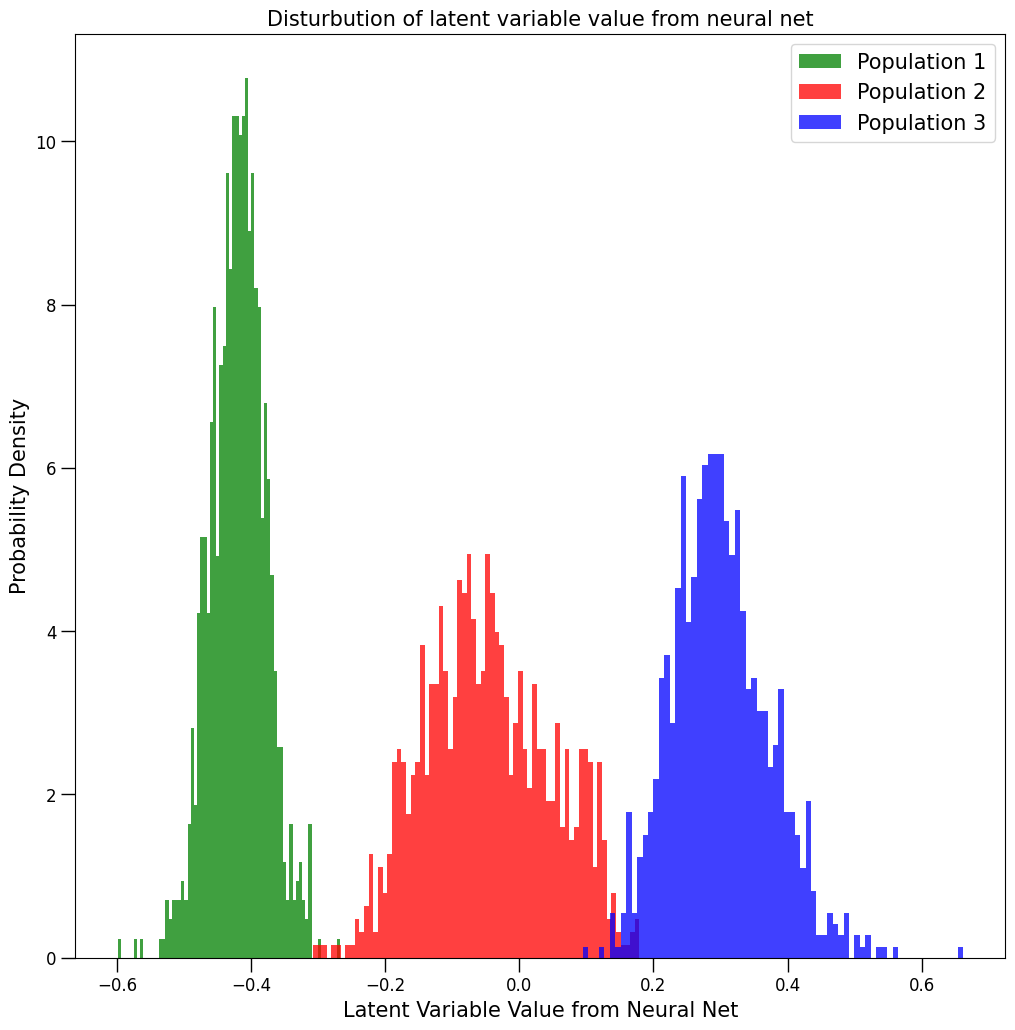

In [5]:
latent_dim = 1  # Dimension of our latent space
vae, encoder = model_vae(latent_dim)
vae.compile(optimizer='rmsprop', loss=nll, 
            weighted_metrics=None,
            loss_weights=None,
            sample_weight_mode=None)

vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=0)

z_test = encoder.predict(x_train, batch_size=batch_size)

plt.figure(figsize=(12, 12))
plt.hist(z_test[:900], 70, density=1, facecolor='green', alpha=0.75, label='Population 1')
plt.hist(z_test[900:1800], 70, density=1, facecolor='red', alpha=0.75, label='Population 2')
plt.hist(z_test[1800:], 70, density=1, facecolor='blue', alpha=0.75, label='Population 3')
plt.title('Disturbution of latent variable value from neural net', fontsize=15)
plt.xlabel('Latent Variable Value from Neural Net', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()
